# HIV Methylation Age: Benchmarking Models

### Imports and Helper Functions

In [31]:
import os 
if os.getcwd().endswith('Benchmarks'):
    os.chdir('..')

In [32]:
import NotebookImport
from Setup.Imports import *

In [33]:
from Setup.MethylationAgeModels import run_horvath_model, run_hannum_model

In [34]:
from Setup.Read_HIV_Data import *

### Read in Datasets

In [35]:
df_meth = pd.read_hdf('/data_ssd/methylation_norm.h5', 'quant_BMIQ_adj')

In [36]:
store = pd.HDFStore('/data_ssd/methylation_norm.h5')

In [37]:
labels = store['labels']
labels = labels.set_index('sampleNames')['studyIndex']
l2 = labels.map({'s1':'Hannum','s3':'EPIC','s2':'Primary Cohort'})

In [38]:
df_meth_n = pd.read_hdf('/data_ssd/methylation_norm.h5', 'BMIQ_Horvath')

n2 = flow_sorted_data.groupby(cell_type, axis=1).mean()
avg = n2[cell_counts.columns].dot(cell_counts.ix[df_meth_n.columns].T)
d2 = df_meth_n.ix[avg.index, df_meth_n.columns].dropna(axis=[0,1], how='all')
cc = avg.mean(1)
df_meth_n = (d2 - avg).add(cc, axis=0).dropna(how='all')

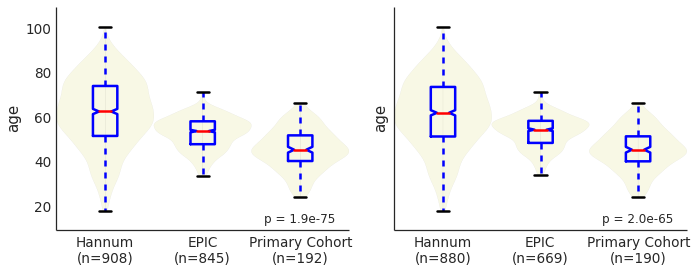

In [39]:
#Do not import
fig, axs = subplots(1,2, figsize=(10,4), sharey=True)
violin_plot_pandas(l2, age, ax=axs[0])
violin_plot_pandas(l2.ix[study.index], age, ax=axs[1])
for ax in axs:
    prettify_ax(ax)
    ax.set_xlabel('')
fig.tight_layout()

## Run Age Predictions

In [40]:
pred = run_hannum_model(df_meth)
pred_horvath = run_horvath_model(df_meth_n)
pred_c = (pred_horvath + pred) / 2
pred_c.name = 'Predicted Age (Combined)'

All Patients

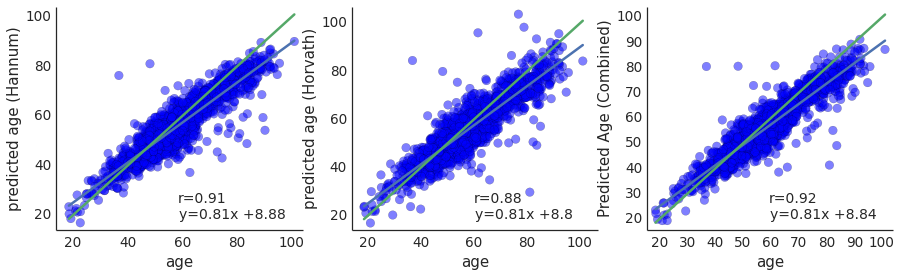

In [41]:
#Do not import
fig, axs = subplots(1,3, figsize=(15,4))

pts = labels.ix[labels != 's2'].index
plot_regression(age.ix[pts], pred, ax=axs[0])
plot_regression(age.ix[pts], pred_horvath.ix[pred.index], ax=axs[1])
plot_regression(age.ix[pts], pred_c.ix[pred.index], ax=axs[2])

In [42]:
pts = labels.index.difference(ti(study.isin(['HIV Short','HIV Long'])))
m1_adj, m2_adj, mc_adj = two_step_adjustment(pred, pred_horvath, age, labels.ix[pts])

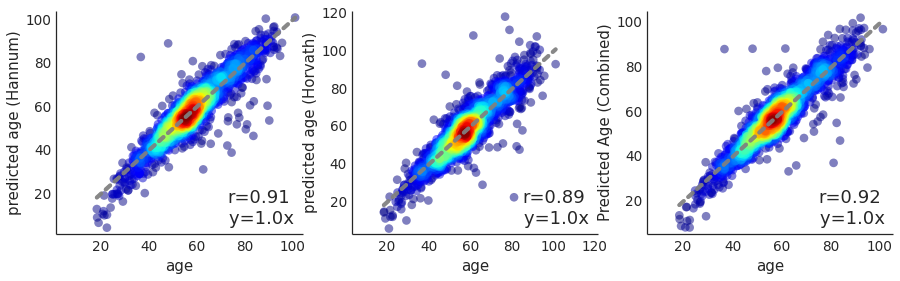

In [43]:
#Do not import
fig, axs = subplots(1,3, figsize=(15,4))
plot_regression(age, m1_adj, ax=axs[0], density=True)
plot_regression(age, m2_adj, ax=axs[1], density=True)
plot_regression(age, mc_adj, ax=axs[2], density=True)

Only Hannum Data 
* Both used this in training 
* This was the full training set for Hannum, a subset for Horvath

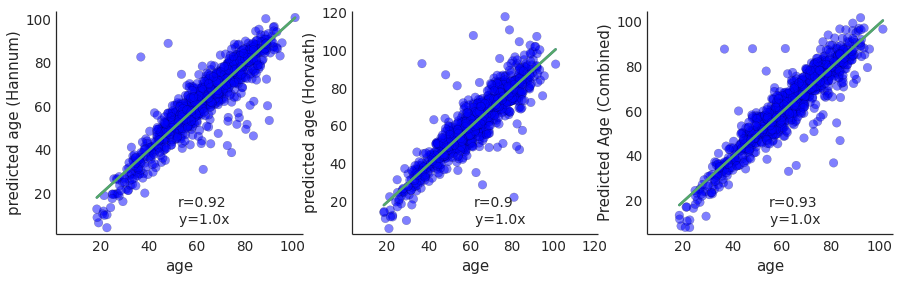

In [44]:
#Do not import
fig, axs = subplots(1,3, figsize=(15,4))

plot_regression(age.ix[ti(labels=='s1')], m1_adj, ax=axs[0])
plot_regression(age.ix[ti(labels=='s1')], m2_adj, ax=axs[1])
plot_regression(age.ix[ti(labels=='s1')], mc_adj, ax=axs[2])

EPIC Data 
* Not used in training for either study

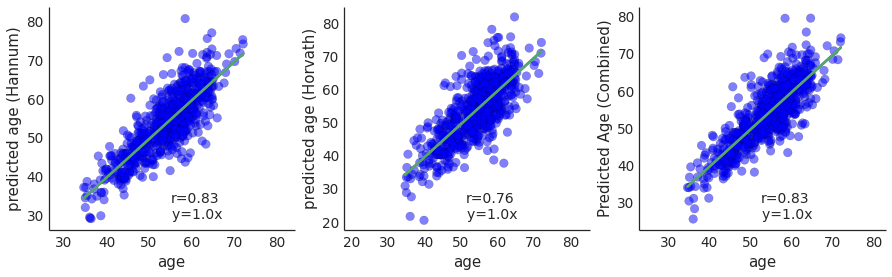

In [45]:
#Do not import
fig, axs = subplots(1,3, figsize=(15,4))

plot_regression(age.ix[ti(labels=='s3')], m1_adj, ax=axs[0])
plot_regression(age.ix[ti(labels=='s3')], m2_adj, ax=axs[1])
plot_regression(age.ix[ti(labels=='s3')], mc_adj, ax=axs[2])

Control samples from our current study

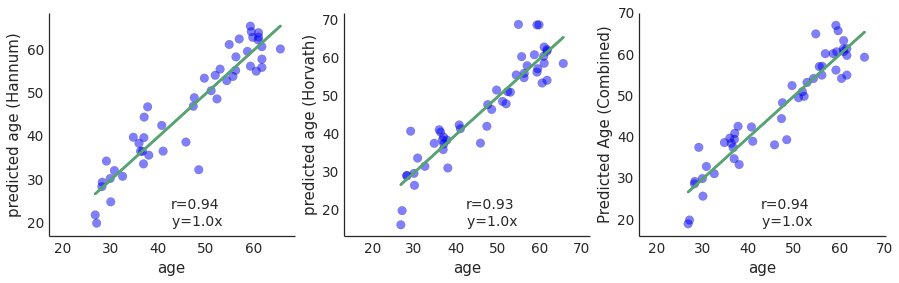

In [46]:
#Do not import
fig, axs = subplots(1,3, figsize=(15,4))

plot_regression(age.ix[ti(labels=='s2')], m1_adj, ax=axs[0])
plot_regression(age.ix[ti(labels=='s2')], m2_adj, ax=axs[1])
plot_regression(age.ix[ti(labels=='s2')], mc_adj, ax=axs[2])

In [47]:
dd = pd.DataFrame({(s, m.name): model_fit(m.ix[ti(l2 == s)], age) for s in l2.unique()
                  for m in [m1_adj, m2_adj, mc_adj]})
dd = dd.unstack().unstack(1).T
dd

EPIC                             Hannum                             Primary Cohort                            
                            n     r error (years) % error      n     r error (years) % error              n     r error (years) % error
Predicted Age (Combined)  669  0.83          3.68    6.86    902  0.93          4.50    8.00             48  0.94          3.23    7.73
predicted age (Hannum)    669  0.83          3.65    6.79    902  0.92          4.84    8.91             48  0.94          3.50    8.17
predicted age (Horvath)   669  0.76          4.67    8.82    902  0.90          5.40    9.37             48  0.93          3.51    8.35

Long term HIV infected patients

## Limit to Set of Patients Being Studied

* Males
* Between 25-68 years old

In [48]:
in_set = pd.Series(pred.index.isin(study.index), pred.index)
exclude_pts = ti(study.isin(['HIV Short','HIV Long']))
in_set = in_set.ix[in_set.index.difference(exclude_pts)]

In [49]:
in_set.value_counts()

True     1649
False      32
dtype: int64

Looking at the diffence in age advancement from the patients in the set to those withheld.

In [50]:
pts = in_set.index
m1_adj, m2_adj, mc_adj = two_step_adjustment(pred, pred_horvath, age, labels.ix[pts])

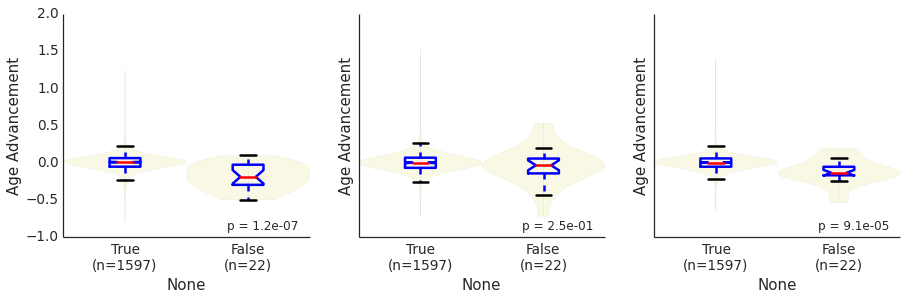

In [51]:
#Do not import
fig, axs = subplots(1,3, figsize=(15,4), sharey=True)
violin_plot_pandas(in_set, (m1_adj - age) / age, ax=axs[0])
violin_plot_pandas(in_set, (m2_adj - age) / age, ax=axs[1])
violin_plot_pandas(in_set, (mc_adj - age) / age, ax=axs[2])
for ax in axs:
    prettify_ax(ax)
    ax.set_ylabel('Age Advancement')

In [52]:
pts = ti(in_set)
m1_adj, m2_adj, mc_adj = two_step_adjustment(pred, pred_horvath, age, labels.ix[pts])

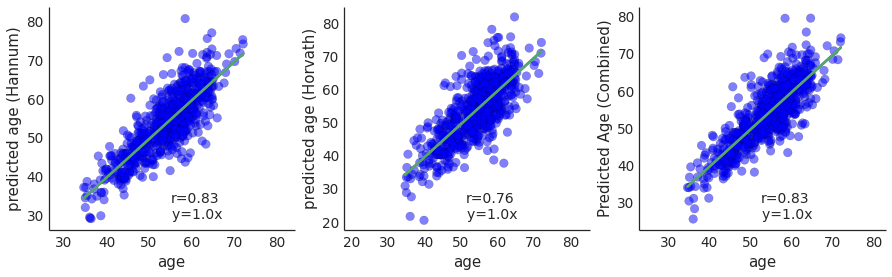

In [53]:
#Do not import
fig, axs = subplots(1,3, figsize=(15,4))

plot_regression(age.ix[ti(labels=='s3')], m1_adj, ax=axs[0])
plot_regression(age.ix[ti(labels=='s3')], m2_adj, ax=axs[1])
plot_regression(age.ix[ti(labels=='s3')], mc_adj, ax=axs[2])

In [54]:
pts = ti(in_set).difference(ti(labels == 's2'))
m1_adj, m2_adj, mc_adj = two_step_adjustment(pred, pred_horvath, age, labels.ix[pts])

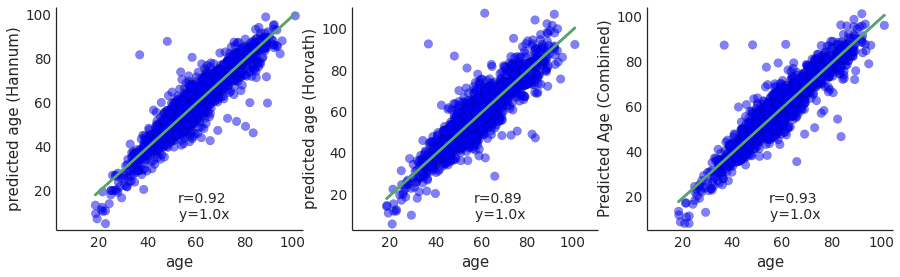

In [55]:
#Do not import
fig, axs = subplots(1,3, figsize=(15,4))

plot_regression(age, m1_adj, ax=axs[0])
plot_regression(age, m2_adj, ax=axs[1])
plot_regression(age, mc_adj, ax=axs[2])

## Patients Not in Study Set

All Patients

In [56]:
pts = ti(in_set == False).difference(ti(labels == 's2'))
m1_adj, m2_adj, mc_adj = two_step_adjustment(pred, pred_horvath, age, labels.ix[pts])

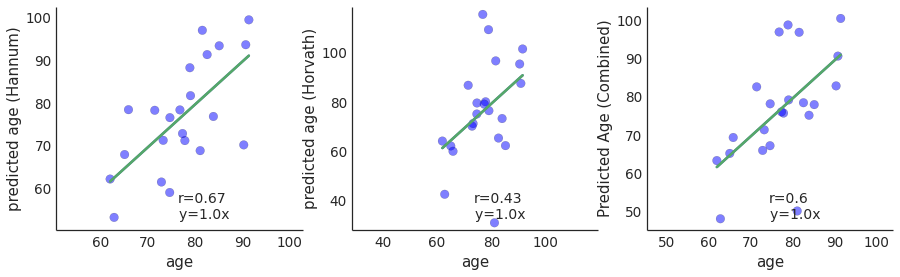

In [57]:
#Do not import
fig, axs = subplots(1,3, figsize=(15,4))

plot_regression(age, m1_adj, ax=axs[0])
plot_regression(age, m2_adj, ax=axs[1])
plot_regression(age, mc_adj, ax=axs[2])

Females 25-68

In [58]:
pts = ti((age >= 25.) & (age <= 68.) & (gender == 'F'))
m1_adj, m2_adj, mc_adj = two_step_adjustment(pred, pred_horvath, age, labels.ix[pts])

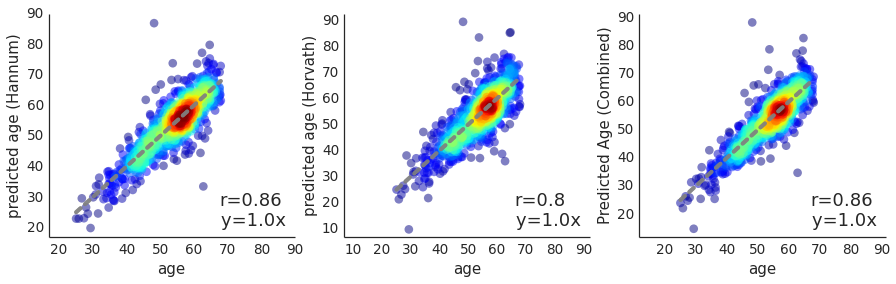

In [59]:
#Do not import
fig, axs = subplots(1,3, figsize=(15,4))

plot_regression(age, m1_adj, ax=axs[0], density=True)
plot_regression(age, m2_adj, ax=axs[1], density=True)
plot_regression(age, mc_adj, ax=axs[2], density=True)